# Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [40]:
bodies = pd.read_csv('../data/processed_bodies.csv')
bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2754 entries, 0 to 2753
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      2754 non-null   int64 
 1   subreddit       2754 non-null   object
 2   body            2754 non-null   object
 3   processed_body  2720 non-null   object
dtypes: int64(1), object(3)
memory usage: 86.2+ KB


In [41]:
bodies.dropna(inplace = True)

# Modelling bodies from r/DJs and r/musicians: Logistic Regression

**TrainTestSpliting**

In [42]:
# Creating a binarized target column musicians:0, DJs:1
bodies['labels'] = bodies['subreddit'].map({'musicians':0, 'DJs':1})

In [43]:
# Creating target(y) and predictor(X) variables
ybodies = bodies['labels']
Xbodies = bodies['processed_body']

In [44]:
ybodies.value_counts(normalize = True)

labels
1    0.515441
0    0.484559
Name: proportion, dtype: float64

In [45]:
# Split the data into the training and testing sets.
Xbodies_train, Xbodies_test, ybodies_train, ybodies_test = train_test_split(Xbodies,
                                                    ybodies,
                                                    test_size=0.33,
                                                    stratify=ybodies,
                                                    random_state=42)

**Count Vectorizer and Logistic Regression: Gridsearching over the Pipeline**

In [46]:
bodies_pipeline_1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [47]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000], # How many words the average person has in their lexicon 
    'cvec__stop_words': [None, 'english'], 
    'cvec__min_df': [2, 4], # 
    'cvec__max_df': [0.99, 0.95, 0.8], 
    'lr__penalty': ['l1', 'l2', 'elasticnet', None]
}

In [48]:
gs_1 = GridSearchCV(bodies_pipeline_1,
                 pipe_params,
                 n_jobs = -1)

gs_1.fit(Xbodies_train, ybodies_train)
print(gs_1.best_score_)
gs_1.best_params_

# error due to solver , some penalties don't work with specific solvers - try changing to 'liblinear'.

0.9165783531536956


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

{'cvec__max_df': 0.99,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__stop_words': None,
 'lr__penalty': 'l2'}

## Model Evaluation: Logistic Regression

In [49]:
bodies_predictions_1 = gs_1.predict(Xbodies_test)

In [50]:
#Accuracy 
print(gs_1.score(Xbodies_train, ybodies_train))
print(gs_1.score(Xbodies_test, ybodies_test))

#.1 or more in general tends to be overfit. But consider the baseline score, if its tonnes better, then dont really matter. 

0.9978046103183315
0.9242761692650334


In [51]:
# Misclassification rate 
print(1 - gs_1.score(Xbodies_train, ybodies_train))
print(1 - gs_1.score(Xbodies_test, ybodies_test))

0.002195389681668547
0.07572383073496658


In [52]:
#Calculating Specificity
#Confusion Matrix 
tn, fp, fn, tp = confusion_matrix(ybodies_test, bodies_predictions_1).ravel()

specificity = tn / (tn + fp)
print(f'Our model specificity: {specificity}')

Our model specificity: 0.9379310344827586


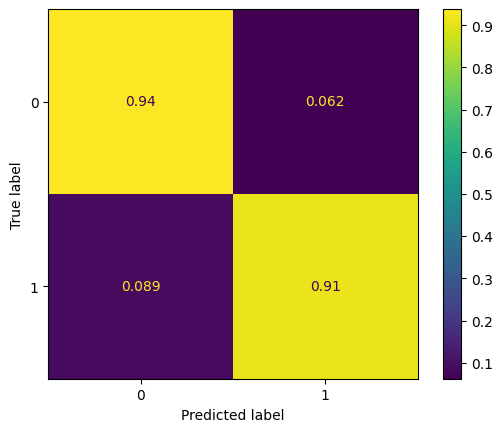

In [68]:
ConfusionMatrixDisplay.from_estimator(gs_1, Xbodies_test, ybodies_test, normalize = 'true');

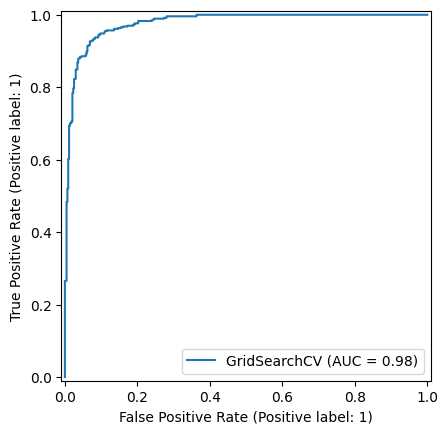

In [54]:
RocCurveDisplay.from_estimator(gs_1, Xbodies_test, ybodies_test);
# how is the model doing at different classification thresholds. the closer to a right angle the better the model is?

In [55]:
classification_report(ybodies_test, bodies_predictions_1)

'              precision    recall  f1-score   support\n\n           0       0.91      0.94      0.92       435\n           1       0.94      0.91      0.93       463\n\n    accuracy                           0.92       898\n   macro avg       0.92      0.92      0.92       898\nweighted avg       0.92      0.92      0.92       898\n'

In [56]:
# Checking recall, good for understanding how model deals with false negatives
recall_1 = tp / (tp + fn)

print(f'Recall: {recall_1}')

Recall: 0.9114470842332614


# Modelling bodies from r/DJs and r/musicians: Multinomial Naive Bayes

In [57]:
bodies_pipeline_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('NB', MultinomialNB())
])

In [58]:
pipe_params_2 = {
    'cvec__max_features': [2000, 3000, 4000], # How many words the average person has in their lexicon 
    'cvec__stop_words': [None, 'english'], 
    'cvec__min_df': [2, 4], # 
    'cvec__max_df': [0.99, 0.95, 0.8], 
    'NB__alpha': [0.1, 0.5, 1.0]
}

In [59]:
gs_2 = GridSearchCV(bodies_pipeline_2,
                 pipe_params_2,
                 n_jobs = -1)

gs_2.fit(Xbodies_train, ybodies_train)
print(gs_2.best_score_)
gs_2.best_params_

0.9160334186361585


{'NB__alpha': 0.1,
 'cvec__max_df': 0.99,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__stop_words': None}

## Model Evaluation: Multinomial Naive Bayes

In [60]:
bodies_predictions_2 = gs_2.predict(Xbodies_test)

In [61]:
#Accuracy 
print(gs_2.score(Xbodies_train, ybodies_train))
print(gs_2.score(Xbodies_test, ybodies_test))

#.1 or more in general tends to be overfit. But consider the baseline score, if its tonnes better, then dont really matter. 

0.9560922063666301
0.920935412026726


In [62]:
# Misclassification rate 
print(1 - gs_2.score(Xbodies_train, ybodies_train))
print(1 - gs_2.score(Xbodies_test, ybodies_test))

0.04390779363336994
0.07906458797327398


In [63]:
#Calculating Specificity
#Confusion Matrix 
tn, fp, fn, tp = confusion_matrix(ybodies_test, bodies_predictions_2).ravel()

specificity_2 = tn / (tn + fp)
print(f'Our model specificity: {specificity_2}')

Our model specificity: 0.903448275862069


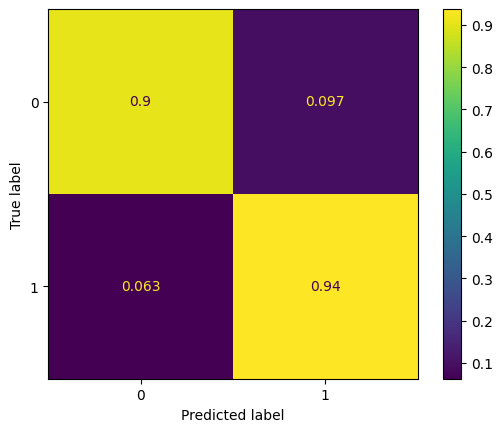

In [69]:
ConfusionMatrixDisplay.from_estimator(gs_2, Xbodies_test, ybodies_test, normalize = 'true');

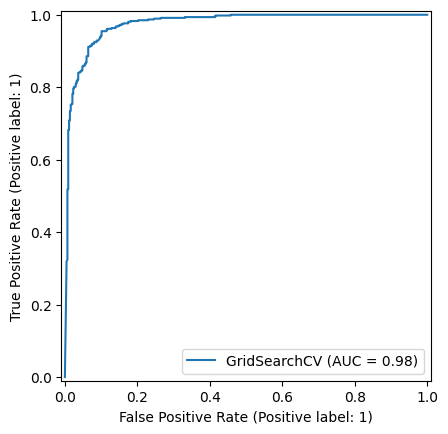

In [65]:
RocCurveDisplay.from_estimator(gs_2, Xbodies_test, ybodies_test);
# how is the model doing at different classification thresholds. the closer to a right angle the better the model is "Explanation from Hank Butler". 

In [66]:
classification_report(ybodies_test, bodies_predictions_2)

'              precision    recall  f1-score   support\n\n           0       0.93      0.90      0.92       435\n           1       0.91      0.94      0.92       463\n\n    accuracy                           0.92       898\n   macro avg       0.92      0.92      0.92       898\nweighted avg       0.92      0.92      0.92       898\n'

In [67]:
# Checking recall, good for understanding how model deals with false negatives
recall_2 = tp / (tp + fn)

print(f'Recall: {recall_2}')

Recall: 0.937365010799136


# Evaluation Summary

In this instance (modelling bodies) the Logistic Regression model performs marginally better than Naive Bayes on accuracy metric. However I have however chosen not to place weight on this bodies notebook and instead favour the titles notebook for 2 reasons..

1. Sample size is significantly smaller than the titles notebook.
2. Whilst EDA showed that there were clear differences in top occuring words between djs and musicians post bodies, the higher overall word length of bodies (and larger discrepancy between maximum word length and minimum word length) means that there is a larger chance that text preprocessing with spaCY has removed contextuality of the bodies of text.
3. Titles has a greater chance of capturing the most important essence of the post getting to the crux of the post more directly; titles are designed for this reason. 